# Gonzalez's Combined Anti-retroviral Therapy Model

The modeling approach in Gonzalez *et al.* [1] inherits a great deal from dos Santos's seminal paper [2]. Many of the parameters from that study are adopted in this later paper, and the added parts of the new model can be viewed as extensions of the original approach in that article. Like that study, Gonzalez *et al.* use Moore's eight-cell neighborhood and periodic borders. Also like that study, Gonzalez *et al.* use the same lattice structure for their cellular automata ($700\times700$), probability of infection ($P_{HIV}$), number of initially infected cells (determined by $P_{infec}$), percentage of neighboring $A_2$-cells necessary to infect a healthy cells ($x$), and time-steps before an infected-$A_1$ cell is discovered by the immune system ($\tau$). The parameters for this model are displayed in Table 1.


|  __Symbol__ | __Definition__                                                        |      __Value__     |
|:-----------:|-----------------------------------------------------------------------|:------------------:|
|     $L$     | Number of cells                                                       |   $700\times700$   |
|  $P_{HIV}$  | Probability of infection                                              |  $5\times10^{-2}$  |
| $P_{infec}$ | Number of initially infected calls                                    |  $1\times10^{-5}$  |
|  $P_{reg}$  | Probability of a dead cell becoming a healthy cell                    | $9.9\times10^{-1}$ |
|     $x$     | Percentage of neighboring $A_2$-cells needed to infect a healthy cell |       $50\%$       |
|    $\tau$   | Time-steps before infected-$A_1$ discovered by immune system          |          4         |

<p style="text-align: center;"> __Table 1.__ Parameters of the Model</p>

The innovation of this paper lies in the way that it models the effects of two classes of general antiretroviral therapies (ARTs), or drugs that slow the rate of HIV replication and buoy the concentration of healthy cells in the system above the critical threshold of 20% below which a patient enters the final stage of infection: AIDS.

A common therapy used is the combination of two nucleoside reverse transcriptase inhibitors $($NRTIs$)$ and either a protease inhibitor $($PI$)$ or a non-nucleoside reverse transcriptase inhibitor $($NNRTI$)$ [1]. NRTI and NNRTI are classified as substrate inhibitors. When absorbed into a cell infected with the virus they inhibit viral replication and halt its ability to infect other cells. An HIV protease is an enzyme that severs synthesized polyproteins at the places that are most necessary to build the components of an infectious HIV virion. A protease inhibitor halts the process of virus replication, rendering a species of non-infectious virus. Over time the effectiveness of PIs has been observed to decrease as the virus builds resistance to the treatment [3,4].

The implementation of the drug therapies in this model involves a function that calculates the effectiveness of a given drug at any time-step as a function of the drug's maximum effectiveness and the concentration of infected cells $($infected-$A_1$ and infected-$A_2)$ at the moment the therapy is introduced. The authors developed this equation to match specific biological requirements that had been observed in clinical trials [3]:

- a treatment's effectiveness should have a maximum value that is a function of the initial concentration of infected cells.
- right after the treatment is administered, the effectiveness of the drug should be at its lowest value while the concentration of infected cells is also at its minimum value.
- it should model the increase in viral turnover and the corresponding increase in infected cells that has been observed in clinical research.

The equation they created is as follows, with index $j$ representing a given drug treatment $($reverse transcriptase inhibitor or protease inhibitor$)$, $P_{0j}$ representing the maximum effectiveness of a treatment, $D_{I0}$ representing the concentration of infected cells at the beginning of the treatment, and $D_I(t)$ representing the concentration of infected cells at time-step $t$ (the behavior of this function is displayed in Figure 1):

<p style="text-align: center;"> $P_j(t) = P_{0j}(\frac{D_I(t)}{D_{I0}})^\frac{2D_{I0}}{1-D_{I0}}(\frac{1-D_I(t)}{1-D_{I0}})^2$ </p>


The step process under therapeutic intervention in which cell states are updated involves three more cell states: healthy cells which have absorbed a reverse transcriptase inhibitor (RTI), healthy cells which have absorbed a protease inhibitor (PI), and cells that have absorbed both (RTP). These new cell states are subject to different rules, whereby infection is either less likely (in the case of either RTI or PI) or impossible (as in RTP). (The relationship between the biological mechanics of the drug therapies and the rules of the model are imperfect. For instance, a cell that has absorbed a protease inhibitor can still become infected, but the production of viral particles by such a cell will be halted during the replication process, resulting in a non-infectious viral particle. The rules, however, do achieve the overall effect of the drug therapies, which is to limit the spread of infection, even if the methods are inexact.) There are four new rules that determine state transitions under combined antiretroviral therapy, or cART:

- A healthy cell becomes $H_{RTP}$ with probability $P_{RTI} \times P_{PI}$; or becomes $H_{P}$ with probability $(1 - P_{RTI}) \times P_{PI}$; or becomes $H_{RT}$ with probability $P_{RTI} \times (1 - P_{PI})$; or becomes an infected-$A_1$ cell with probability $(1 - P_{RTI}) \times (1 - P_{PI})$, given there is at least one infected-$A_1$ cell or 4 $A_2$ cells in its neighborhood; otherwise the cell remains healthy.
- A healthy cell $H_{RT}$ becomes $H_{RTP}$ with probability $P_{RTI}$; or remains $H_{RT}$ with probability $(1 - P_{PI}) \times P_{RTI}$; or becomes an infected-$A_1$ cell with probability $(1 - P_{RTI}) \times (1 - P_{PI})$, provided it has at least one $A_1$ cell in its vicinity or at least 4 $A_2$ cells nearby; otherwise it becomes a normal healthy cell.
- A healthy cell $H_P$ becomes an $H_{RTP}$ cell with probability $P_{RTI}$; or remains an $H_P$ cell with probability $(1 - P_{RTI}) \times P_{PI}$; or becomes an infected-$A_1$ cell with probability $(1 - P_{RTI}) \times (1 - P_{PI})$, given it has at least one $A_1$ or four $A_2$ neighbors; otherwise it becomes a normal healthy cell.
- A healthy cell $H_{RTP}$ always becomes a normal healthy cell in the next time-step.

The probability of a cell to absorb a drug varies from step to step according to the concentration of the different cell states as well as the initial conditions at which the therapy is initialized. The maximum effectiveness values are set by variables in the simulation. The authors of the paper always considered the maximum effectiveness of these to be equal.

# Code for the model

In [1]:
import numpy as np
from numba import jit,prange

In [2]:
# CONSTANTS OF THE MODEL
# Cell states:

CELL_H  = 0
CELL_H_rt = 1
CELL_H_p = 2
CELL_H_rtp = 3

CELL_D  = 4

CELL_A1 = 84
CELL_A2 = 21

# Step function for non-therapy

In [65]:

@jit(nopython=True, parallel=True)
def nonTherapyStep(grid, buffer, taugrid, P_repH, P_repI, tau):
    healthy = 0
    dead    = 0
    
    for i in prange(1, grid.shape[0]-1):
        for j in range(1, grid.shape[1]-1):
            # Note: putting the 'rules' in a seperate function leads to a significant performance impact.
            value = grid[i,j]

            if value == CELL_H:
                neighbor_sum = (grid[i-1,j-1] + grid[i-1,j] + grid[i-1,j+1] +
                                grid[i,  j-1]               + grid[i,  j+1] +
                                grid[i+1,j-1] + grid[i+1,j] + grid[i+1,j+1])

                if (neighbor_sum >= CELL_A1):
                    buffer[i,j] = CELL_A1       

            elif value == CELL_A1:
                taugrid[i,j] += 1
                if taugrid[i,j] == tau:
                    taugrid[i,j] = 0
                    buffer[i,j] = CELL_A2

            elif value == CELL_A2:
                buffer[i,j] = CELL_D
                
            else: # elif value == CELL_D:
                if np.random.random() <= P_repI:
                    buffer[i,j] = CELL_A1
                elif np.random.random() <= P_repH:
                    buffer[i,j] = CELL_H
                # or else the cell remains dead
                
            if (value == CELL_H or value == CELL_H_rt or
                value == CELL_H_p or value == CELL_H_rtp):
                healthy += 1
            elif (value == CELL_D):
                dead += 1

    return healthy, (grid.shape[0]-2)*(grid.shape[1]-2)-healthy-dead, dead

# Step function for cART (both drug therapies)

In [66]:

@jit(nopython=True, parallel=True)
def rtpStep(grid, buffer, taugrid, P_repH, P_repI, tau, P_rti, P_pi):
    healthy = 0
    dead    = 0
    
    for i in prange(1, grid.shape[0]-1):
        for j in range(1, grid.shape[1]-1):
            # Note: putting the 'rules' in a seperate function leads to a significant performance impact.
            value = grid[i,j]

            if value == CELL_H:
                if (np.random.random() <= (P_rti * P_pi)):
                    buffer[i,j] = CELL_H_rtp
                    continue
                    
                if (np.random.random() <= ((1 - P_rti) * P_pi)):
                    buffer[i,j] = CELL_H_p
                    continue
                    
                if (np.random.random() <= (P_rti * (1 - P_pi))):
                    buffer[i,j] = CELL_H_rt
                    continue
                    
                neighbor_sum = (grid[i-1,j-1] + grid[i-1,j] + grid[i-1,j+1] +
                                grid[i,  j-1]               + grid[i,  j+1] +
                                grid[i+1,j-1] + grid[i+1,j] + grid[i+1,j+1])

                if ((neighbor_sum >= CELL_A1) and (np.random.random() <= ((1 - P_rti) * (1 - P_pi)))):
                    buffer[i,j] = CELL_A1
                    
                #else: cell remains healthy
                    
            elif value == CELL_H_rt:
                if (np.random.random() <= P_pi):
                    buffer[i,j] = CELL_H_rtp
                    continue
                    
                if (np.random.random() <= ((1 - P_pi) * P_rti)):
                    continue
                
                neighbor_sum = (grid[i-1,j-1] + grid[i-1,j] + grid[i-1,j+1] +
                                grid[i,  j-1]               + grid[i,  j+1] +
                                grid[i+1,j-1] + grid[i+1,j] + grid[i+1,j+1])

                if ((neighbor_sum >= CELL_A1) and (np.random.random() <= ((1 - P_rti) * (1 - P_pi)))):
                    buffer[i,j] = CELL_A1
                    continue
                    
                buffer[i,j] = CELL_H

            elif value == CELL_H_p:                
                if (np.random.random() <= P_rti):
                    buffer[i,j] = CELL_H_rtp
                    continue
                    
                if (np.random.random() <= ((1 - P_rti) * P_pi)):
                    continue
                
                neighbor_sum = (grid[i-1,j-1] + grid[i-1,j] + grid[i-1,j+1] +
                                grid[i,  j-1]               + grid[i,  j+1] +
                                grid[i+1,j-1] + grid[i+1,j] + grid[i+1,j+1])

                if ((neighbor_sum >= CELL_A1) and (np.random.random() <= ((1 - P_rti) * (1 - P_pi)))):
                    buffer[i,j] = CELL_A1
                    continue
                    
                buffer[i,j] = CELL_H
                    
            elif value == CELL_H_rtp:
                buffer[i,j] = CELL_H
                    
            elif value == CELL_A1:
                taugrid[i,j] += 1
                if taugrid[i,j] == tau:
                    taugrid[i,j] = 0
                    buffer[i,j] = CELL_A2

            elif value == CELL_A2:
                buffer[i,j] = CELL_D
                
            else: # elif value == CELL_D:
                if np.random.random() <= P_repI:
                    buffer[i,j] = CELL_A1
                elif np.random.random() <= P_repH:
                    buffer[i,j] = CELL_H
                # or else the cell remains dead
                
            if (value == CELL_H or value == CELL_H_rt or
                value == CELL_H_p or value == CELL_H_rtp):
                healthy += 1
            elif (value == CELL_D):
                dead += 1
   
    return healthy, (grid.shape[0]-2)*(grid.shape[1]-2)-healthy-dead, dead


# Step function for Reverse-transcriptase Inhibitor Therapy

In [62]:

@jit(nopython=True, parallel=True)
def rtiStep(grid, buffer, taugrid, P_repH, P_repI, tau, P_rti, P_pi):
    healthy = 0
    dead    = 0
    
    for i in prange(1, grid.shape[0]-1):
        for j in range(1, grid.shape[1]-1):
            # Note: putting the 'rules' in a seperate function leads to a significant performance impact.
            value = grid[i,j]

            if value == CELL_H:                
                if (np.random.random() <= (P_rti * (1 - P_pi))):
                    buffer[i,j] = CELL_H_rt
                    continue
                
                neighbor_sum = (grid[i-1,j-1] + grid[i-1,j] + grid[i-1,j+1] +
                                grid[i,  j-1]               + grid[i,  j+1] +
                                grid[i+1,j-1] + grid[i+1,j] + grid[i+1,j+1])

                if ((neighbor_sum >= CELL_A1) and (np.random.random() <= ((1 - P_rti) * (1 - P_pi)))):
                    buffer[i,j] = CELL_A1
                    
                #else: cell remains healthy
                    
            elif value == CELL_H_rt:               
                if (np.random.random() <= ((1 - P_pi) * P_rti)):
                    continue
                
                neighbor_sum = (grid[i-1,j-1] + grid[i-1,j] + grid[i-1,j+1] +
                                grid[i,  j-1]               + grid[i,  j+1] +
                                grid[i+1,j-1] + grid[i+1,j] + grid[i+1,j+1])

                if ((neighbor_sum >= CELL_A1) and (np.random.random() <= ((1 - P_rti) * (1 - P_pi)))):
                    buffer[i,j] = CELL_A1
                    continue

                buffer[i,j] = CELL_H
            
            elif value == CELL_A1:
                taugrid[i,j] += 1
                if taugrid[i,j] == tau:
                    taugrid[i,j] = 0
                    buffer[i,j] = CELL_A2
                    
            elif value == CELL_A2:
                buffer[i,j] = CELL_D
                
            else: # elif value == CELL_D:
                if np.random.random() <= P_repI:
                    buffer[i,j] = CELL_A1
                elif np.random.random() <= P_repH:
                    buffer[i,j] = CELL_H
                # or else the cell remains dead
                
            if (value == CELL_H or value == CELL_H_rt or
                value == CELL_H_p or value == CELL_H_rtp):
                healthy += 1
            elif (value == CELL_D):
                dead += 1
   
    return healthy, (grid.shape[0]-2)*(grid.shape[1]-2)-healthy-dead, dead


# Step function for Protease Inhibitor Therapy

In [61]:

@jit(nopython=True, parallel=True)
def piStep(grid, buffer, taugrid, P_repH, P_repI, tau, P_rti, P_pi):
    healthy = 0
    dead    = 0
    
    for i in prange(1, grid.shape[0]-1):
        for j in range(1, grid.shape[1]-1):
            # Note: putting the 'rules' in a seperate function leads to a significant performance impact.
            value = grid[i,j]

            if value == CELL_H:
                neighbor_sum = (grid[i-1,j-1] + grid[i-1,j] + grid[i-1,j+1] +
                                grid[i,  j-1]               + grid[i,  j+1] +
                                grid[i+1,j-1] + grid[i+1,j] + grid[i+1,j+1])

                if ((neighbor_sum >= CELL_A1) and (np.random.random() <= ((1 - P_rti) * (1 - P_pi)))):
                    buffer[i,j] = CELL_A1
                    
                elif (np.random.random() <= ((1 - P_rti) * P_pi)):
                    buffer[i,j] = CELL_H_p
                    
                #else: cell remains healthy

            elif value == CELL_H_p:
                neighbor_sum = (grid[i-1,j-1] + grid[i-1,j] + grid[i-1,j+1] +
                                grid[i,  j-1]               + grid[i,  j+1] +
                                grid[i+1,j-1] + grid[i+1,j] + grid[i+1,j+1])

                if ((neighbor_sum >= CELL_A1) and (np.random.random() <= ((1 - P_rti) * (1 - P_pi)))):
                    buffer[i,j] = CELL_A1
                    
                elif (np.random.random() <= ((1 - P_rti) * P_pi)):
                    continue
                    
                else:
                    buffer[i,j] = CELL_H
                    
            elif value == CELL_A1:
                taugrid[i,j] += 1
                if taugrid[i,j] == tau:
                    taugrid[i,j] = 0
                    buffer[i,j] = CELL_A2

            elif value == CELL_A2:
                buffer[i,j] = CELL_D
                
            else: # elif value == CELL_D:
                if np.random.random() <= P_repI:
                    buffer[i,j] = CELL_A1
                elif np.random.random() <= P_repH:
                    buffer[i,j] = CELL_H
                # or else the cell remains dead

            if (value == CELL_H or value == CELL_H_rt or
                value == CELL_H_p or value == CELL_H_rtp):
                healthy += 1
            elif (value == CELL_D):
                dead += 1
   
    return healthy, (grid.shape[0]-2)*(grid.shape[1]-2)-healthy-dead, dead


In [60]:
# eff() calculates the effectiveness of a treatment given:
#   1. a maximum effectiveness of the drug (P_0j)
#   2. a concentration of infected cells at initiation of treatment (D_I0)
#   3. a concentration of infected cells at a given time step (D_I)
#
# it returns a float between 0 and 1

@jit
def eff(P_0j, D_I0, D_I):
    return ( P_0j * ((D_I / D_I0)**((2 * D_I0) / (1 - D_I0))) * ((1 - D_I) / (1 - D_I0))**2 )

# Functions to run the model

In [59]:
#@jit(parallel=True)
def run(timesteps, replications, nonTherapySteps=300, drugTherapy=rtpStep, L = 800, P_HIV = 0.05, P_reg = 0.99, P_infec = 1e-05, tau = 4, P_0j = .5):
    """
    Runs the model.
    """
    
    # Probability that a dead cell will be replaced by a healthy or infected cell is a function of P_infec and P_reg
    P_repH = (1 - P_infec) * P_reg
    P_repI = P_infec * P_reg
    
    @jit
    def init_grid():
        grid = np.zeros((L+2, L+2), dtype=np.uint8)

        for i in range(1, grid.shape[0]-1):
            for j in range(1, grid.shape[1]-1):
                if np.random.random() < P_HIV:
                    grid[i,j] = CELL_A1

        return grid, np.zeros_like(grid)
    
    def periodic_borders(grid):
        grid[1:-1, 0] = grid[1:-1,-2]
        grid[1:-1,-1] = grid[1:-1, 1]
        grid[ 0,1:-1] = grid[-2,1:-1]
        grid[-1,1:-1] = grid[ 1,1:-1]
        grid[ 0, 0]   = grid[-2,-2]
        grid[ 0,-1]   = grid[-2, 1]
        grid[-1, 0]   = grid[ 1,-2]
        grid[-1,-1]   = grid[ 1, 1]
    
    results_H = np.zeros((replications, timesteps))
    results_A = np.zeros((replications, timesteps))
    results_D = np.zeros((replications, timesteps))
    
    global saved_H
    saved_H = [0, 0, 0]
    
    global saved_A
    saved_A = [0, 0, 0]
    
    global saved_D
    saved_D = [0, 0, 0]
    
    # Add simulations storage for frames output
    simulations = [[] for i in range(replications)]
    frames = [[] for i in range(replications)]
    #record=[[] for i in range(replications)]
    
    for run in range(replications):
        grid, taugrid = init_grid()
        buffer = grid.copy()

        for t in range(timesteps):
            if(t == 1):
                saved_H[0] = results_H[run,t - 1]
                saved_A[0] = results_A[run,t - 1]
                saved_D[0] = results_D[run,t - 1]
                
                frames[run].append([grid.copy()])
            elif(t == int(timesteps / 2)):
                saved_H[1] = results_H[run,t]
                saved_A[1] = results_A[run,t]
                saved_D[1] = results_D[run,t]
                
                frames[run].append([grid.copy()])
            elif(t == timesteps - 1):
                saved_H[2] = results_H[run,t]
                saved_A[2] = results_A[run,t]
                saved_D[2] = results_D[run,t]
                
                frames[run].append([grid.copy()])
            
            #record[run].append([grid.copy()])
            
            #np.savez_compressed("rep="+str(run)+"step="+str(t)+".npz",np.array(grid))
            
            periodic_borders(grid)
            
            # Add updated frame (only to halfway point)
            simulations[run] += [list(grid.copy())]
            
            if t < nonTherapySteps:
                healthy, infected, dead = nonTherapyStep(grid, buffer, taugrid, P_repH, P_repI, tau)
                
            else:
                if t == nonTherapySteps:
                    # Save the concentration of infected cells at step treatment begins
                    initC = results_A[run, t-1] / ((L-2) * (L-2))
                    newT=t-2
                    while initC == 0.0:
                        initC = results_A[run, newT] / ((L-2) * (L-2))
                        newT -= 1
                    
                tC = results_A[run, t-1] / ((L-2 * L-2))
                P_rti = eff(P_0j, initC, tC)
                P_pi = eff(P_0j, initC, tC)
                
                healthy, infected, dead = drugTherapy(grid, buffer, taugrid, P_repH, P_repI, tau, P_rti, P_pi)
            
            results_H[run,t] = healthy # / ((L-2)*(L-2))
            results_A[run,t] = infected # / ((L-2)*(L-2))
            results_D[run,t] = dead # / ((L-2)*(L-2))
            
            grid[:,:] = buffer[:,:]
            
            
    # Globally store the most recent, final results
    global resultsH, resultsA, resultsD, simulationsG
    resultsH = results_H[replications - 1, timesteps - 1]
    resultsA = results_A[replications - 1, timesteps - 1]
    resultsD = results_D[replications - 1, timesteps - 1]
    simulationsG = simulations
    
    global picture
    picture = frames
    
    
    return results_H, results_A, results_D

In [9]:
#@jit(parallel=True)
def runOneTherapies(weeks=60, replications=1):
    results_Hrti, results_Arti, results_Drti = run(weeks, replications, drugTherapy=rtiStep)
    return results_Hrti, results_Arti, results_Drti

In [10]:
#%time hC_rti, iC_rti, dC_rti = runOneTherapies()
#np.array(picture).shape

In [73]:
saved_A

[32316.0, 0.0, 0.0]

In [11]:
#%time hC_rti, iC_rti, dC_rti = runOneTherapies()
#replications
#data = np.load('1_800_0.05_0.99_1e-05_4.npz',mmap_mode='r')
#data['arr_0'].shape
#data['arr_0'][1][802*300:802*301].shape

In [12]:
# runAllTherapies() runs the model for 600 weeks with variable amount of replications per drug therapy type
# It gathers results from each type of drug therapy combination, as well as one run without any intervention
def runAllTherapies(weeks=600, replications=5):
    results_Hrti, results_Arti, results_Drti = run(weeks, replications, drugTherapy=rtiStep)
    results_Hpi, results_Api, results_Dpi = run(weeks, replications, drugTherapy=piStep)
    results_Hrtp, results_Artp, results_Drtp = run(weeks, replications)
    results_H, results_A, results_D = run(weeks, replications, 601)
    
    return results_Hrti, results_Arti, results_Drti, results_Hpi, results_Api, results_Dpi, results_Hrtp, results_Artp, results_Drtp, results_H, results_A, results_D

In [13]:
# Run all different types of therapies, as well as a non-intervention scenario for the appropriate timesteps and replications
#%time hC_rti, iC_rti, dC_rti, hC_pi, iC_pi, dC_pi, hC_rtp, iC_rtp, dC_rtp, hC, iC, dC = runAllTherapies()

In [35]:
# Export simulation results (Results after 10 years) to CSV
import time
from memory_profiler import memory_usage
Ls = [800]

p_hivs = [0.05]
p_repls =  [0.99]
p_infecs = [1e-05]

tauls = [4]
replications = 2
timesteps = 600

total_runs = len(Ls) * len(p_hivs) * len(p_repls) * len(p_infecs) * len(tauls) * replications
print(total_runs)

output = "gonzalezout.csv"

# Create the output file
f = open(output, "w")
f.write("Run #,L,Phiv,Prepl,Pinfec,taul,RAM (MB),Time,Class [H],Class [A],Class [D]\n")
f.close()

2


In [67]:
# Run and output the simulations
run_count = 0
for L in Ls:
    for p_hiv in p_hivs:
        for p_repl in p_repls:
            for p_infec in p_infecs:
                for taul in tauls:
                    run_count = run_count + 1

                    # Storage variables
                    times = []
                    mem_usages = []
                    class_h = []
                    class_a = []
                    class_d = []
                    simulations = []

                    for i in range(0, replications):
                        # Run the simulation
                        t0 = time.time()#nonTherapySteps=300, drugTherapy=rtpStep, L = 800, P_HIV = 0.05, P_reg = 0.99, P_infec = 1e-05, tau = 4, P_0j = .5
                        #results_H, results_A, results_D = run(600, 1, nonTherapySteps=300, drugTherapy=rtpStep,L = L, P_HIV = p_hiv, P_reg = p_repl, P_infec = p_infec, tau = taul, P_0j = .5)
                        
                        mem_usage = memory_usage((run, [timesteps, 1, 300, rtpStep, L, p_hiv, p_repl, p_infec, taul, replications]))
                        t1 = time.time()
                        
                        # Store results
                        times += [t1 - t0]
                        mem_usages += [max(mem_usage)]
                        class_h += [resultsH]
                        class_a += [resultsA]
                        class_d += [resultsD]
                        simulations += [simulationsG[0]]
                        
                        #np.savez_compressed("rtp"+str(i + 1) + "_" + str(L) + "_" + str(p_hiv) + "_" + str(p_repl) + "_" + str(p_infec) + "_" + str(taul) + ".npz", np.array(simulationsG))
                        
                        print("Simulation " + str(run_count) + "/" + str(total_runs) + " complete!")

                    #Write results
                    f = open(output, "a")
                    for i in range(0, replications):
                        f.write(str(run_count) + "," + str(L) + "," + str(p_hiv) + "," + str(p_repl) + "," + str(p_infec) + "," + str(taul) + "," + str(mem_usages[i]) + "," + str(times[i]) + "," + str(class_h[i]) + "," + str(class_a[i]) + "," + str(class_d[i]) + "\n")
                        run_count += 1
                    f.close()
                    run_count -= 1
                    
                    # Store the counts globally
                    global count_h
                    count_h = class_h
                    
                    global count_a
                    count_a = class_a
                    
                    global count_d
                    count_d = class_d
                    
                    # Export image features
                    for i in range(0, replications):
                        np.savez_compressed("rtp_"+str(i + 1) + "_" + str(L) + "_" + str(p_hiv) + "_" + str(p_repl) + "_" + str(p_infec) + "_" + str(taul) + ".npz", np.array(simulations[i]))
                    print("Done")

Simulation 1/2 complete!
Simulation 1/2 complete!
Done


In [34]:
np.array(simulationsG).shape

MemoryError: Unable to allocate 8.99 GiB for an array with shape (5, 5, 481200, 802) and data type uint8

In [68]:
print(picture[0][2][0])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [69]:
import numpy as np
import scipy.misc as smp
import matplotlib.pyplot as plt

#CELL_H  = 0
#CELL_H_rt = 1
#CELL_H_p = 2
#CELL_H_rtp = 3

#CELL_D  = 4

#CELL_A1 = 84
#CELL_A2 = 21

w = 3
h = 1
fig = plt.figure(figsize=(8, 15))
columns = 3
rows = 2

for i in range(1, 2):
    for j in range(0, 3):
        # Create a 100x100x3 array of 8 bit unsigned integers
        data = np.zeros((800,800,3), dtype=np.uint8)
        # Convert picture array to image
        for row in range(0, len(data)):
            for col in range(0, len(data)):
                pixel = picture[i][j][0][row][col]
                if pixel == 0 or pixel == 1 or pixel == 2 or pixel == 3:
                    data[row, col] = [255, 255, 255] # CELL_H == CELL_H_rt == CELL_H_p == CELL_H_rtp  == WHITE
                elif (pixel == 4):
                    data[row, col] = [0, 0, 0]       # CELL_D  == BLACK
                elif (pixel == 84):
                    data[row, col] = [0, 128, 0]     # CELL_A1 == GREEN
                elif (pixel == 21):
                    data[row, col] = [0, 255, 0]     # CELL_A2 == LIME
        
        tmp = fig.add_subplot(rows, columns, (3 * i) + j + 1)

        if j == 0:
            tmp.set_title('t = 0')
        elif j == 1:
            tmp.set_title('t = 260')
        else:
            tmp.set_title('t = 520')

        plt.imshow(data)
        
plt.show()    

IndexError: list index out of range

<Figure size 576x1080 with 0 Axes>

In [70]:
print(saved_H)

print(saved_A)

print(saved_D)

[607684.0, 0.0, 0.0]
[32316.0, 0.0, 0.0]
[0.0, 0.0, 0.0]


# Verification of the model

The first step in verifying our implementation of this article's CA approach was ensuring that the probabilities produced by our function match those produced by the authors. We produced Figure 1, which displays the behavior of the authors' equation given various parameters. It is identical to the figure displaying the same information in Gonzalez's paper (reproduced below).

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [74]:
# j is a variable for the drug type being used:
#   it can mean either:
#      -RT (reverse-transcriptase inhibitor)
#      -P (Protease inhibitor)

# P_0j is the maximum effectiveness of the drug
# P_j indicates the effectiveness of a drug for a given timestep
# D_I0 is the concentration of infected cells at initiation of treatment
#      It is represented as an array, each of which will correspond to a line of a given color on the graph
# D_I denotes the concentration of infected cells at a given time t
#      It will be the x-axis values

#P_0j = .9

P_0j=.5
D_I0 = [.2, .4, .6, .8]
D_I = np.arange(0, 1.01, .01)

In [76]:
# effectiveness() calculates the effectiveness of a treatment given:
#   1. a maximum effectiveness of the drug (P_0j)
#   2. a concentration of infected cells at initiation of treatment (D_I0)
#   3. a concentration of infected cells at a given time step (D_I)
#
# it returns a float between 0 and 1
#
# For reference, this formula is printed and described on page 4707 of the article

def effectiveness(P_0j, D_I0, D_I):
    return ( P_0j * ((D_I / D_I0)**((2 * D_I0) / (1 - D_I0))) * ((1 - D_I) / (1 - D_I0))**2 )

In [77]:
# fillEffectArrays() generates a default dictionary, with keys for each D_I0 value given as an array
# and values for those keys corresponding to all values returned by the effectiveness() function.
# It returns the default dictionary to be stored for visualization.

def fillEffectArrays(P_0j, D_I0, D_I):
    
    # effectiveness() values for each D_I0 value will be stored in 4 different arrays to be displayed on graph. These
    # arrays are stored in a default dictionary with the names in the array "names"
    # the array "names" has all the names of the arrays to be filled, and helps in filling the lists in a for loop

    P_j = defaultdict(list)
    names = ["P_j1", "P_j2", "P_j3", "P_j4"]
    
    for i,e in enumerate(D_I0):
        for j in D_I:
            P_j[names[i]].append(effectiveness(P_0j, e, j))
            
    return P_j

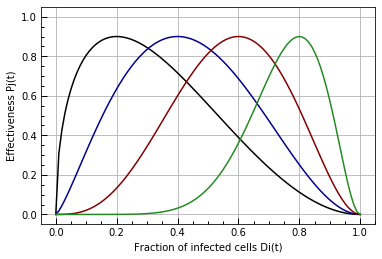

In [27]:
# Store values into a dictionary called P_j

P_j = fillEffectArrays(P_0j, D_I0, D_I)

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

fig, ax = plt.subplots()

colors = ['black', 'darkblue', 'maroon', 'forestgreen']

x_tick_labels = ['0.0', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0']

color_i = 0

for i in P_j.keys():
    plt.plot(P_j[i], color=colors[color_i])
    color_i+=1
   
plt.xlabel('Fraction of infected cells Di(t)')
plt.ylabel('Effectiveness Pj(t)')

ax.minorticks_on()
ax.set_xticklabels(x_tick_labels)
ax.tick_params(which='minor',length=3,width=1,direction='in')
ax.tick_params(which='major', length=6, width=1, direction='in')
ax.set_ylim(-0.05, 1.05)

plt.grid()

# Save figure using 72 dots per inch
# plt.savefig("fig5.png", dpi=72)
    
plt.show()

__Figure 1__. Effectiveness $P_j(t)$ as a function of the concentration of infected cells $D_I(t)$ at the initiation of treatment. Each line has a maximum effectiveness $P_{0j}$ of 90% effective (0.9), and each color represents a different concentration of infected cells at beginning of treatment ($D_{I0}$): the black line represents 0.2, blue represents 0.4, red represents 0.6, and green represents 0.8. (The graph presented here is a recreation of Figure 5 on page 4708 from Gonzalez's paper.)

The next step in our validation process involved implementing the model with cART. Figure 2 shows the results of several simulation groups run with divergent initial conditions. There are four graphs: (a) shows the results of only using reverse transcriptase inhibitor therapy (RTI), (b) shows only protease inhibitor therapy (PI), (c) a combination of both (cART), and (d) a baseline scenario with no therapy intervention. All interventions were initiated at time-step 300, and the maximum effectiveness of the drug therapies was set at 0.5. Each graph represents the average concentration of cell states healthy, infected ($A_1 + A_2$), and dead cells across 600 time-steps over 50 simulation runs. The error bars represent the size of one standard deviation at various time-steps throughout the process.

In [78]:
# save the average values over multiple runs

hC_rti_av = hC_rti.mean(axis=0)
iC_rti_av = iC_rti.mean(axis=0)
dC_rti_av = dC_rti.mean(axis=0)

hC_pi_av = hC_pi.mean(axis=0)
iC_pi_av = iC_pi.mean(axis=0)
dC_pi_av = dC_pi.mean(axis=0)

hC_rtp_av = hC_rtp.mean(axis=0)
iC_rtp_av = iC_rtp.mean(axis=0)
dC_rtp_av = dC_rtp.mean(axis=0)

hC_av = hC.mean(axis=0)
iC_av = iC.mean(axis=0)
dC_av = dC.mean(axis=0)

aids_threshold = [.2 for i in range(0,600)]

NameError: name 'hC_rti' is not defined

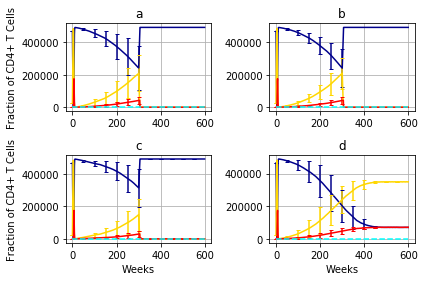

In [29]:
x = [(50 * i) for i in range(12)]
colors = ['darkblue', 'gold', 'red']


L1 = [hC_rti, iC_rti, dC_rti]
L2 = [hC_rti_av, iC_rti_av, dC_rti_av]

L3 = [hC_pi, iC_pi, dC_pi]
L4 = [hC_pi_av, iC_pi_av, dC_pi_av]

L5 = [hC_rtp, iC_rtp, dC_rtp]
L6 = [hC_rtp_av, iC_rtp_av, dC_rtp_av]

L7 = [hC, iC, dC]
L8 = [hC_av, iC_av, dC_av]


plt.subplot(221)
for i, e in enumerate(L1):
    plt.plot(L2[i], color=colors[i])
    plt.errorbar(x, [L2[i][j] for j in x], [(np.std(e, axis=0))[j] for j in x], 
                 linestyle='None', ecolor=colors[i], capsize=2)
plt.plot(aids_threshold, color='aqua', linestyle="--")
plt.title('a')
plt.ylabel('Fraction of CD4+ T Cells')
plt.grid()

plt.subplot(222)
for i, e in enumerate(L3):
    plt.plot(L4[i], color=colors[i])
    plt.errorbar(x, [L4[i][j] for j in x], [(np.std(e, axis=0))[j] for j in x], 
                 linestyle='None', ecolor=colors[i], capsize=2)
plt.plot(aids_threshold, color='aqua', linestyle="--")
plt.title('b')
plt.grid()

plt.subplot(223)
for i, e in enumerate(L5):
    plt.plot(L6[i], color=colors[i])
    plt.errorbar(x, [L6[i][j] for j in x], [(np.std(e, axis=0))[j] for j in x], 
                 linestyle='None', ecolor=colors[i], capsize=2)
plt.plot(aids_threshold, color='aqua', linestyle="--")
plt.title('c')
plt.xlabel('Weeks')
plt.ylabel('Fraction of CD4+ T Cells')
plt.grid()

plt.subplot(224)
for i, e in enumerate(L7):
    plt.plot(L8[i], color=colors[i])
    plt.errorbar(x, [L8[i][j] for j in x], [(np.std(e, axis=0))[j] for j in x], 
                 linestyle='None', ecolor=colors[i], capsize=2)
plt.plot(aids_threshold, color='aqua', linestyle="--")
plt.title('d')
plt.xlabel('Weeks')
plt.grid()

plt.tight_layout()

# # Save figure using 72 dots per inch
# plt.savefig("fig6gonzalez.png", dpi=72)

plt.show()

__Figure 2__. Line plots of the average concentration of cell types across multiple runs of the CA. The blue lines represent the fraction of healthy cells; the yellow lines represent infected cells $(A_1$ and $A_2)$; and the red lines represent dead cells. The maximum treatment effectiveness is set low ($P_{0j} = 0.5$) and the treatment is initiated at $300$ weeks. (a) is only with Reverse Transcriptase Inhibitor therapy (RTI). (b) is only with Protease Inhibitor therapy. (c) is with a combination of both drugs (cART). And (d) represents the simulation in the absence of any therapy. (The blue dashed line represents the threshold of AIDS: 0.2 of healthy cells.)

In all graphs, we can see that the dynamics of infection are being achieved by our model. There is an initial period of acute infection which corresponds to a substantial drop in healthy cells, which is followed by a long period of sustained deterioration during the chronic stage of infection. In the first two graphs (a and b), we see that upon initializing therapy, the concentration of healthy cells gets a bump, which corresponds to a fall in infected cell concentrations. This initial improvement in patient condition, however, is followed by a drop in healthy cell concentration that is slightly more steep than the baseline scenario in (d). The result is that, with small variation, the patient's healthy cell count drops below the threshold and the final stage of infection, AIDS, is reached. With a combination of the two drug therapies, however, there is a much greater stabilization in the healthy cell count into the 600th week.

When comparing our results to those achieved by Gonzalez *et al*, we see that the general dynamics of HIV infection match, as well as the behavior of our models after the introduction of drug therapies. We also notice, however, that the time-scale on which certain events happen are slightly shifted in our results. For instance, comparing the baseline, nonintervention scenarios shows that in our model, the concentrations of healthy and infected cells meet on average around week 350, whereas in Gonzalez's results this convergence takes place around week 280. Afterward, we also notice that their patient on average would reach the final stage of infection around the 400th week, but in our results this event takes place closer to week 600. It is not immediately apparent why our results seem out-of-sync with the results of the authors; it could be due to the randomness built into the simulation, or the fact that an average over 50 simulations can still show some signification deviations if there are an unusual number of outliers cases in a trial. Another possibility could be a subtle difference in our implementation of the rule structures, which could lead to a significant shift in results over a long enough period of time. 

__Figure 3.__ Line plots of the average concentration of cell types across multiple runs of the CA. The blue lines represent the fraction of healthy cells; the yellow lines represent infected cells $(A_1$ and $A_2)$; and the red lines  represent dead cells. The maximum treatment effectiveness is set low ($P_{0j} = 0.5$) and the treatment is initiated at $300$ weeks. (a) is only with Reverse Transcriptase Inhibitor therapy (RTI). (b) is only with Protease Inhibitor therapy. (c) is with a combination of both drugs (cART). And (d) represents the simulation in the absence of any therapy. (The blue dashed line represents the threshold of AIDS: 0.2 of healthy cells.)

# Free-virion vs Cell-to-cell Transmission

Displayed in Figure 4 are the results of our drug therapy model run with an extended Moore's neighborhood. Here we used the same $x$ value as in the dos Santos extended model: $x = 35,000$.

There was quite a bit more variation in the average cell concentrations in this model after the introduction of drug therapy. It is not immediately clear why this would be the case. The averages and standard deviations of each cell type, however, are still within the expected ranges.

Like the dos Santos model, our replication of Gonzalez's drug therapy model makes the general dynamics of the infection occur at an accelerated rate (c) ). We also notice that the healthy cell concentration with the extended neighborhood is about 15% lower at the 600th week than the normal Moore's neighborhood. 

## Code for the Extended Moore Neighborhood for the Gonzalez model

In [91]:
import numpy as np
from numba import jit,prange
import math

# Constants of the model

CELL_H  = 0
CELL_H_rt = 1
CELL_H_p = 2
CELL_H_rtp = 3
CELL_D  = 4
CELL_A1 = 84
CELL_A2 = 21


In [92]:

@jit(nopython=True, parallel=True)
def nonTherapyStep(grid, buffer, taugrid, P_repH, P_repI, tau, dist):

    healthyC = 0
    deadC    = 0

    
    for i in prange(3, (grid.shape[0])-3):
        for j in range(3, (grid.shape[1])-3):

            value = grid[i,j]

            if value == CELL_H:
                healthyC += 1
                
                D = 1
                
                neighbor_sum = (grid[i-1,j-1] + grid[i-1,j] + grid[i-1,j+1] +
                                grid[i,  j-1]               + grid[i,  j+1] +
                                grid[i+1,j-1] + grid[i+1,j] + grid[i+1,j+1])

                if (neighbor_sum >= CELL_A1) and (np.random.random() <= dist[D]):
                    buffer[i,j] = CELL_A1  
                    continue
                
                # else check neighborhood D = 2
                D = 2
                    
                neighbor_sum2 = (grid[i-2,j-2] + grid[i-2,j-1] + grid[i-2,j] + grid[i-2,j+2] + grid[i-2,j+2] +
                                 grid[i-1,j-2] +                                               grid[i-1,j+2] +
                                 grid[i , j-2] +                                               grid[i , j+2] +
                                 grid[i+1,j-2] +                                               grid[i+1,j+2] +
                                 grid[i+2,j-2] + grid[i+2,j-1] + grid[i+2,j] + grid[i+2,j+2] + grid[i+2,j+2])

                if (neighbor_sum2 >= CELL_A1) and (np.random.random() <= dist[D]):
                    buffer[i,j] = CELL_A1
                    continue
                
                # else check neighborhood D = 3
                D = 3

                neighbor_sum3 = (grid[i-3,j-3] + grid[i-3,j-2] + grid[i-3,j-1] + grid[i-3, j] + grid[i-3,j+1] + grid[i-3,j+2] + grid[i-3,j+3] + 
                                 grid[i-2,j-3] +                                                                                grid[i-2,j+3] +
                                 grid[i-1,j-3] +                                                                                grid[i-1,j+3] +
                                 grid[i  ,j-3] +                                                                                grid[i  ,j+3] +
                                 grid[i+1,j-3] +                                                                                grid[i+1,j+3] +
                                 grid[i+2,j-3] +                                                                                grid[i+2,j+3] +
                                 grid[i+3,j-3] + grid[i+3,j-2] + grid[i+3,j-1] + grid[i+3, j] + grid[i+3,j+1] + grid[i+3,j+2] + grid[i+3,j+3])

                if (neighbor_sum3 >= CELL_A1) and (np.random.random() <= dist[D]):
                    buffer[i,j] = CELL_A1
                    
                # or else cell remains healthy

            elif value == CELL_A1:
                taugrid[i,j] += 1
                if taugrid[i,j] == tau:
                    taugrid[i,j] = 0
                    buffer[i,j] = CELL_A2

            elif value == CELL_A2:
                buffer[i,j] = CELL_D
                
            else: # elif value == CELL_D:
                deadC += 1
                
                if np.random.random() <= P_repI:
                    buffer[i,j] = CELL_A1
                elif np.random.random() <= P_repH:
                    buffer[i,j] = CELL_H
                # or else the cell remains dead
        
    return healthyC, (grid.shape[0]-6)*(grid.shape[1]-6)-healthyC-deadC, deadC


## Therapy step

In [98]:

@jit(nopython=True, parallel=True)
def antiRetroviralStep(grid, buffer, taugrid, P_repH, P_repI, tau, P_rti, P_pi, dist):
    
    healthyC = 0
    deadC    = 0
    
    for i in prange(3, (grid.shape[0])-3):
        for j in range(3, (grid.shape[1])-3):
            value = grid[i,j]

            if value == CELL_H:
                healthyC += 1
                
                if (np.random.random() <= (P_rti * P_pi)):
                    buffer[i,j] = CELL_H_rtp
                    continue
                    
                elif (np.random.random() <= ((1 - P_rti) * P_pi)):
                    buffer[i,j] = CELL_H_p
                    continue
                    
                elif (np.random.random() <= (P_rti * (1 - P_pi))):
                    buffer[i,j] = CELL_H_rt
                    continue
                    
                neighbor_sum = (grid[i-1,j-1] + grid[i-1,j] + grid[i-1,j+1] +
                                grid[i,  j-1]               + grid[i,  j+1] +
                                grid[i+1,j-1] + grid[i+1,j] + grid[i+1,j+1])

                if (neighbor_sum >= CELL_A1) and (np.random.random() <= ((1 - P_rti) * (1 - P_pi))):
                    buffer[i,j] = CELL_A1 
                    continue
                   
                # or else check neighborhood D = 2
                D = 2
                    
                neighbor_sum2 = (grid[i-2,j-2] + grid[i-2,j-1] + grid[i-2,j] + grid[i-2,j+2] + grid[i-2,j+2] +
                                 grid[i-1,j-2] +                                               grid[i-1,j+2] +
                                 grid[i , j-2] +                                               grid[i , j+2] +
                                 grid[i+1,j-2] +                                               grid[i+1,j+2] +
                                 grid[i+2,j-2] + grid[i+2,j-1] + grid[i+2,j] + grid[i+2,j+2] + grid[i+2,j+2])

                if (neighbor_sum2 >= CELL_A1) and (np.random.random() <= dist[D]) and (np.random.random() <= ((1 - P_rti) * (1 - P_pi))):
                    buffer[i,j] = CELL_A1
                    continue

                # or else check neighborhood D = 3
                D = 3

                neighbor_sum3 = (grid[i-3,j-3] + grid[i-3,j-2] + grid[i-3,j-1] + grid[i-3, j] + grid[i-3,j+1] + grid[i-3,j+2] + grid[i-3,j+3] + 
                                 grid[i-2,j-3] +                                                                                grid[i-2,j+3] +
                                 grid[i-1,j-3] +                                                                                grid[i-1,j+3] +
                                 grid[i  ,j-3] +                                                                                grid[i  ,j+3] +
                                 grid[i+1,j-3] +                                                                                grid[i+1,j+3] +
                                 grid[i+2,j-3] +                                                                                grid[i+2,j+3] +
                                 grid[i+3,j-3] + grid[i+3,j-2] + grid[i+3,j-1] + grid[i+3, j] + grid[i+3,j+1] + grid[i+3,j+2] + grid[i+3,j+3])

                if ((neighbor_sum3 >= CELL_A1) and (np.random.random() <= dist[D]) and (np.random.random() <= ((1 - P_rti) * (1 - P_pi)))):
                    buffer[i,j] = CELL_A1
                    
                #else: cell remains healthy
                    
            elif value == CELL_H_rt:
                healthyC += 1
                    
                if (np.random.random() <= P_pi):
                    buffer[i,j] = CELL_H_rtp
                    continue
                    
                elif (np.random.random() <= ((1 - P_pi) * P_rti)):
                    # cell stays healthy_rt
                    continue
                    
                # check for immediate neighbors that are infected
                
                neighbor_sum = (grid[i-1,j-1] + grid[i-1,j] + grid[i-1,j+1] +
                                grid[i,  j-1]               + grid[i,  j+1] +
                                grid[i+1,j-1] + grid[i+1,j] + grid[i+1,j+1])

                if ((neighbor_sum >= CELL_A1) and (np.random.random() <= ((1 - P_rti) * (1 - P_pi)))):
                    buffer[i,j] = CELL_A1 
                    continue
                 
                # or else check neighborhood D = 2
                D = 2
                    
                neighbor_sum2 = (grid[i-2,j-2] + grid[i-2,j-1] + grid[i-2,j] + grid[i-2,j+2] + grid[i-2,j+2] +
                                 grid[i-1,j-2] +                                               grid[i-1,j+2] +
                                 grid[i , j-2] +                                               grid[i , j+2] +
                                 grid[i+1,j-2] +                                               grid[i+1,j+2] +
                                 grid[i+2,j-2] + grid[i+2,j-1] + grid[i+2,j] + grid[i+2,j+2] + grid[i+2,j+2])

                if ((neighbor_sum2 >= CELL_A1) and (np.random.random() <= dist[D]) and (np.random.random() <= ((1 - P_rti) * (1 - P_pi)))):
                    buffer[i,j] = CELL_A1
                    continue

                # or else check cells of D = 3
                D = 3

                neighbor_sum3 = (grid[i-3,j-3] + grid[i-3,j-2] + grid[i-3,j-1] + grid[i-3, j] + grid[i-3,j+1] + grid[i-3,j+2] + grid[i-3,j+3] + 
                                 grid[i-2,j-3] +                                                                                grid[i-2,j+3] +
                                 grid[i-1,j-3] +                                                                                grid[i-1,j+3] +
                                 grid[i  ,j-3] +                                                                                grid[i  ,j+3] +
                                 grid[i+1,j-3] +                                                                                grid[i+1,j+3] +
                                 grid[i+2,j-3] +                                                                                grid[i+2,j+3] +
                                 grid[i+3,j-3] + grid[i+3,j-2] + grid[i+3,j-1] + grid[i+3, j] + grid[i+3,j+1] + grid[i+3,j+2] + grid[i+3,j+3])

                if ((neighbor_sum3 >= CELL_A1) and (np.random.random() <= dist[D]) and (np.random.random() <= ((1 - P_rti) * (1 - P_pi)))):
                    buffer[i,j] = CELL_A1
                    continue
                
                # or else the cell becomes a normal healthy cell
                buffer[i,j] = CELL_H

            elif value == CELL_H_p:
                healthyC += 1
                    
                if (np.random.random() <= P_rti):
                    buffer[i,j] = CELL_H_rtp
                    continue
                    
                elif (np.random.random() <= ((1 - P_rti) * P_pi)):
                    # cell remains healthy_p
                    continue
                
                neighbor_sum = (grid[i-1,j-1] + grid[i-1,j] + grid[i-1,j+1] +
                                grid[i,  j-1]               + grid[i,  j+1] +
                                grid[i+1,j-1] + grid[i+1,j] + grid[i+1,j+1])

                if ((neighbor_sum >= CELL_A1) and (np.random.random() <= ((1 - P_rti) * (1 - P_pi)))):
                    buffer[i,j] = CELL_A1 
                    continue
                        
                # or else check neighbors of D = 2
                D = 2

                neighbor_sum2 = (grid[i-2,j-2] + grid[i-2,j-1] + grid[i-2,j] + grid[i-2,j+2] + grid[i-2,j+2] +
                                 grid[i-1,j-2] +                                               grid[i-1,j+2] +
                                 grid[i , j-2] +                                               grid[i , j+2] +
                                 grid[i+1,j-2] +                                               grid[i+1,j+2] +
                                 grid[i+2,j-2] + grid[i+2,j-1] + grid[i+2,j] + grid[i+2,j+2] + grid[i+2,j+2])

                if ((neighbor_sum2 >= CELL_A1) and (np.random.random() <= dist[D]) and (np.random.random() <= ((1 - P_rti) * (1 - P_pi)))):
                    buffer[i,j] = CELL_A1
                    continue

                # or else check neighbors of D = 3
                D = 3

                neighbor_sum3 = (grid[i-3,j-3] + grid[i-3,j-2] + grid[i-3,j-1] + grid[i-3, j] + grid[i-3,j+1] + grid[i-3,j+2] + grid[i-3,j+3] + 
                                 grid[i-2,j-3] +                                                                                grid[i-2,j+3] +
                                 grid[i-1,j-3] +                                                                                grid[i-1,j+3] +
                                 grid[i  ,j-3] +                                                                                grid[i  ,j+3] +
                                 grid[i+1,j-3] +                                                                                grid[i+1,j+3] +
                                 grid[i+2,j-3] +                                                                                grid[i+2,j+3] +
                                 grid[i+3,j-3] + grid[i+3,j-2] + grid[i+3,j-1] + grid[i+3, j] + grid[i+3,j+1] + grid[i+3,j+2] + grid[i+3,j+3])

                if ((neighbor_sum3 >= CELL_A1) and (np.random.random() <= dist[D]) and (np.random.random() <= ((1 - P_rti) * (1 - P_pi)))):
                    buffer[i,j] = CELL_A1
                    continue
                    
                # or else cell becomes a normal healthy cell
                buffer[i,j] = CELL_H
                    
            elif value == CELL_H_rtp:
                healthyC += 1
                buffer[i,j] = CELL_H
                    
            elif value == CELL_A1:
                taugrid[i,j] += 1
                if taugrid[i,j] == tau:
                    taugrid[i,j] = 0
                    buffer[i,j] = CELL_A2

            elif value == CELL_A2:
                buffer[i,j] = CELL_D
                
            else: # elif value == CELL_D:
                deadC += 1
                
                if np.random.random() <= P_repI:
                    buffer[i,j] = CELL_A1
                elif np.random.random() <= P_repH:
                    buffer[i,j] = CELL_H
                # or else the cell remains dead
                    
    return healthyC, (grid.shape[0]-6)*(grid.shape[1]-6)-healthyC-deadC, deadC


In [99]:
# eff() calculates the effectiveness of a treatment given:
#   1. a maximum effectiveness of the drug (P_0j)
#   2. a concentration of infected cells at initiation of treatment (D_I0)
#   3. a concentration of infected cells at a given time step (D_I)
#
# it returns a float between 0 and 1

@jit
def eff(P_0j, D_I0, D_I):
    return ( P_0j * ((D_I / D_I0)**((2 * D_I0) / (1 - D_I0))) * ((1 - D_I) / (1 - D_I0))**2 )

## Functions to run the model

In [171]:
def run(timesteps, replications, nonTherapySteps=300, drugTherapy=antiRetroviralStep, L = 800, P_HIV = 0.05, P_reg = 0.99, P_infec = 1e-05, tau = 4, P_0j = .5):
    """
    Runs the model.
    """
    
    # Probability that a dead cell will be replaced by a healthy or infected cell is a function of P_infec and P_reg
    P_repH = (1 - P_infec) * P_reg
    P_repI = P_infec * P_reg
    
    # High, medium, and low transmission rates:
#     P_freeVirion = lambda D: (1/1000)**(D-1) # x-hi
#     P_freeVirion = lambda D: (1/25000)**(D-1) # hi
    P_freeVirion = lambda D: (1/35000)**(D-1) # med
#     P_freeVirion = lambda D: (1/45000)**(D-1) # low

#     gamma = .3

#     P_freeVirion = lambda D: (gamma * math.exp(-gamma*(D-1)))
    
    dist = np.array([P_freeVirion(D) for D in range(4)])
    
    @jit
    def init_grid():
        grid = np.zeros((L+6, L+6), dtype=np.uint8)

        for i in range(3, grid.shape[0]-3):
            for j in range(3, grid.shape[1]-3):
                if np.random.random() < P_HIV:
                    grid[i,j] = CELL_A1

        return grid, np.zeros_like(grid)
    
    def periodic_borders(grid):
        # copy D = 1 neighbors
        grid[3:-3, 2] = grid[3:-3,-4]
        grid[3:-3,-3] = grid[3:-3, 3]
        grid[ 2,3:-3] = grid[-4,3:-3]
        grid[-3,3:-3] = grid[ 3,3:-3]
        grid[ 2, 2]   = grid[-4,-4]
        grid[ 2,-3]   = grid[-4, 3]
        grid[-3, 2]   = grid[ 3,-4]
        grid[-3,-3]   = grid[ 3, 3]

        # copy D = 2 neighbors
        grid[3:-3, 1] = grid[3:-3,-5]
        grid[3:-3,-2] = grid[3:-3, 4]
        grid[ 1,3:-3] = grid[-5,3:-3]
        grid[-2,3:-3] = grid[ 4,3:-3]
        grid[ 2, 1]   = grid[-4,-5]
        grid[ 1, 1]   = grid[-5,-5]
        grid[ 1, 2]   = grid[-5,-4]
        grid[ 1,-2]   = grid[-5, 4]
        grid[ 1,-3]   = grid[-5, 3]
        grid[ 2,-2]   = grid[-4, 4]
        grid[-2, 1]   = grid[ 4,-5]
        grid[-3, 1]   = grid[ 3,-5]
        grid[-2, 2]   = grid[ 4,-4]
        grid[-2,-2]   = grid[ 4, 4]
        grid[-3,-2]   = grid[ 3, 4]
        grid[-2,-3]   = grid[ 4, 3]

        # copy D = 3 neighbors
        grid[3:-3, 0] = grid[3:-3,-6]
        grid[3:-3,-1] = grid[3:-3, 5]
        grid[ 0,3:-3] = grid[-6,3:-3]
        grid[-1,3:-3] = grid[ 5,3:-3]
        grid[ 0, 0]   = grid[-6,-6]
        grid[ 0, 1]   = grid[-6,-5]
        grid[ 0, 2]   = grid[-6,-4]
        grid[ 1, 0]   = grid[-5,-6]
        grid[ 2, 0]   = grid[-4,-6]
        grid[ 0,-3]   = grid[-6, 3]
        grid[ 0,-2]   = grid[-6, 4]
        grid[ 0,-1]   = grid[-6, 5]
        grid[ 1,-1]   = grid[-5,-5]
        grid[ 2,-1]   = grid[-4, 5]
        grid[-3,-1]   = grid[ 3, 5]
        grid[-2,-1]   = grid[ 4, 5]
        grid[-1,-1]   = grid[ 5, 5]
        grid[-1,-2]   = grid[ 5, 4]
        grid[-1,-3]   = grid[ 5, 3]
        grid[-1, 2]   = grid[ 5,-4]
        grid[-1, 1]   = grid[ 5,-5]
        grid[-1, 0]   = grid[ 5,-6]
        grid[-2, 0]   = grid[ 4,-6]
        grid[-3, 0]   = grid[ 3,-6]
    
    results_H = np.zeros((replications, timesteps))
    results_A = np.zeros((replications, timesteps))
    results_D = np.zeros((replications, timesteps))
    
    for run in range(replications):
        grid, taugrid = init_grid()
        buffer = grid.copy()
        
        
        record=[[] for i in range(timesteps)]
        for t in range(timesteps):
            periodic_borders(grid)
            
            if t < nonTherapySteps:
                healthy, infected, dead = nonTherapyStep(grid, buffer, taugrid, P_repH, P_repI, tau, dist)
                
            else:
                if t == nonTherapySteps:
                    # Save the concentration of infected cells at step treatment begins
                    initC = results_A[run, t-1]
                    newT=t-2
                    while initC == 0.0:
                        initC = results_A[run, newT]
                        newT -= 1
                    
                tC = results_A[run, t-1]
                newT = t-2
                while tC == 0.0:
                    tC = results_A[run, newT]
                    newT -= 1
                    
                P_rti = eff(P_0j, initC, tC)
                P_pi = eff(P_0j, initC, tC)
                
                healthy, infected, dead = drugTherapy(grid, buffer, taugrid, P_repH, P_repI, tau, P_rti, P_pi, dist)
            
            results_H[run,t] = healthy / (L*L)
            results_A[run,t] = infected / (L*L)
            results_D[run,t] = dead / (L*L)

            grid[:,:] = buffer[:,:]
            
            record[t]+=list(grid.copy())

            
    return results_H, results_A, results_D, record

In [162]:
# Run the model for 600 weeks with variable amount of replications per drug therapy type
def runAllTherapies(weeks=600, replications=50):
    # Storage variables
    times = []
    mem_usages = []
    class_h = []
    class_a = []
    class_d = []
    for i in range(replications):
        results_H, results_A, results_D, record = run(weeks, 1, nonTherapySteps=20)
        class_h+=[results_H[0,-1]]
        class_a+=[results_A[0,-1]]
        class_d+=[results_D[0,-1]]
        
        np.savez_compressed("run"+str(i+1),record)
     #Write results
    f = open("output.csv", "a")
    f.write("Run #,L,Phiv,Prepl,Pinfec,taul,Class [H],Class [A],Class [D]\n")
    for i in range(0, replications):
        f.write(str(i) + "," + str(800) + "," + str(p_hiv) + "," + str(p_repl) + "," + str(p_infec) + "," + str(taul)  + "," + str(class_h[i]) + "," + str(class_a[i]) + "," + str(class_d[i]) + "\n")
    f.close()
    
    return results_H, results_A, results_D

In [172]:
# %time hC, iC, dC = runAllTherapies()
hC, iC, dC = runAllTherapies(weeks=600,replications=30)

30 [0.6898765625, 0.6905453125, 0.689234375, 0.6738828125, 0.6889828125, 0.6893546875, 0.68875, 0.6877484375, 0.689559375, 0.6886125, 0.689684375, 0.6896171875, 0.6884109375, 0.6892015625, 0.6897859375, 0.6891875, 0.6893578125, 0.6894921875, 0.6889640625, 0.6877671875, 0.688828125, 0.6893765625, 0.6474046875, 0.6893578125, 0.3929546875, 0.6893859375, 0.6850015625, 0.68936875, 0.6015484375, 0.6890578125]


## Visualizations

In [103]:
import matplotlib.pyplot as plt

In [167]:

# Average the values of each step from every simulation run, save that as a new array
hC_av = hC.mean(axis=0)
iC_av = iC.mean(axis=0)
dC_av = dC.mean(axis=0)

# hC_av = hC_rtp.mean(axis=0)
# iC_av = iC_rtp.mean(axis=0)
# dC_av = dC_rtp.mean(axis=0)

aids_threshold = [.2 for i in range(0,600)]


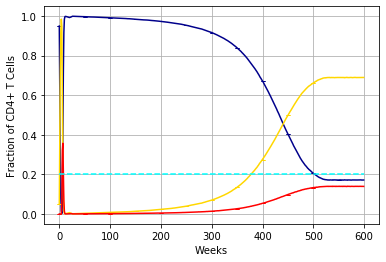

In [170]:
x = [(50 * i) for i in range(12)]
colors = ['darkblue', 'gold', 'red']
labels = ['D = 1', 'D = 2 & 3']

color_map = ['lightblue', 'lightgreen', 'pink']

# L1 = [hC_rtp, iC_rtp, dC_rtp]
L1 = [hC, iC, dC]
L2 = [hC_av, iC_av, dC_av]

for i, e in enumerate(L1):
    plt.plot(L2[i], color=colors[i])
    plt.errorbar(x, [L2[i][j] for j in x], [(np.std(e, axis=0))[j] for j in x], 
                 linestyle='None', ecolor=colors[i], capsize=2)
plt.plot(aids_threshold, color='aqua', linestyle="--")
# ax[0].title('Nonintervention with Free Virions')
plt.xlabel('Weeks')
plt.ylabel('Fraction of CD4+ T Cells')
plt.grid()


# plt.tight_layout()

# # Save figure using 72 dots per inch
# plt.savefig("freevirionRTPtherapy.png", bbox_inches='tight')

plt.show()

In [169]:
f.close()

## References

1. Gonzalez, R.E., Coutinho, S., dos Santos, R.M.Z., de Figueiredo, P.H.: Dynamics of the hiv infection under antiretroviral therapy: A cellular automata approach. Physica A: Statistical Mechanics and its Applications 392(19), 4701–4716 (2013)

2. dos Santos, R.M.Z., Coutinho, S.: Dynamics of hiv infection: A cellular automata approach. Physical review letters 87(16), 168102 (2001)

3. Novitsky, V., Wang, R., Bussmann, H., Lockman, S., Baum, M., Shapiro, R., Thior, I., Wester, C., Wester, C.W., Ogwu, A., et al.: Hiv-1 subtype c-infected individuals maintaining high viral load as potential targets for the test-and-treat approach to reduce hiv transmission. PLoS One 5(4), 10148 (2010)

4. Dutartre, H., Claviere, M., Journo, C., Mahieux, R.: Cell-free versus cellto-cell infection by human immunodeficiency virus type 1 and human tlymphotropic virus type 1: exploring the link among viral source, viral trafficking, and viral replication. Journal of virology 90(17), 7607–7617 (2016)